# Imports, setup, etc...

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p /root/.cache/torch/hub/checkpoints/
!cp /content/drive/MyDrive/inceptionv4-8e4777a0.pth /root/.cache/torch/hub/checkpoints/inceptionv4-8e4777a0.pth

In [ ]:
!pip install albumentations==1.1.0 opencv-python==4.5.4.58 --quiet
!pip install -U segmentation-models-pytorch --quiet

     |████████████████████████████████| 102 kB 5.3 MB/s 
     |████████████████████████████████| 60.3 MB 1.2 MB/s 
     |████████████████████████████████| 47.6 MB 103 kB/s 
     |████████████████████████████████| 88 kB 3.8 MB/s 
     |████████████████████████████████| 376 kB 17.1 MB/s 
     |████████████████████████████████| 58 kB 7.7 MB/s 


In [ ]:
import numpy as np
import os
import cv2 as cv
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import torch
import torch.nn as nn
from torch.nn.functional import softmax
from sklearn.model_selection import KFold
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import defaultdict
import copy
from google.colab.patches import cv2_imshow
from PIL import Image
import segmentation_models_pytorch as smp
%matplotlib inline

In [ ]:
seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
data_path = os.path.join(os.getcwd(), 'drive/MyDrive/data_diploma/SFU/BlastsOnline/')
gt_icm_path = os.path.join(data_path, 'predicted_ICM')
gt_te_path = os.path.join(data_path, 'predicted_TE')
gt_zp_path = os.path.join(data_path, 'predicted_ZP')
images_path = os.path.join(data_path, 'Images')

# MASK BAKING 

In [ ]:
def convert_to_grayscale(img):
    return cv.cvtColor(img, cv.COLOR_BGR2GRAY)

def convert_to_compound_gt(path_to_image):
    """
    Returns compound mask created from 3 one-hot encoded masks. Also returns
    stripped image name for convenience. 
    """
    mask_suffixes = ['ICM_Mask.bmp', 'TE_Mask.bmp', 'ZP_Mask.bmp']
    paths = [gt_icm_path, gt_te_path, gt_zp_path]
    image_name = os.path.basename(path_to_image)[:-4]
    for i, suffix in enumerate(mask_suffixes):
        mask_path = os.path.join(paths[i], f'{image_name} {mask_suffixes[i]}')
        mask = cv.imread(mask_path)
        mask = convert_to_grayscale(mask)
        if i == 0:
            compound_mask = np.zeros_like(mask)
        compound_mask[mask != 0] = i + 1
    return image_name, compound_mask


In [ ]:
image_filepaths = [os.path.join(images_path, d) for d in os.listdir(images_path)]

# Get compound masks
compound_mask_path = os.path.join(data_path, "predicted_compound_gt")
try:
    os.mkdir(compound_mask_path)
except FileExistsError:
    print(f'Folder already exists')

if not os.listdir(compound_mask_path):
    for image_path in tqdm(image_filepaths):
            image_name, compound_mask = convert_to_compound_gt(image_path)
            gt_filepath = os.path.join(compound_mask_path, f'{image_name} Mask.bmp')
            cv.imwrite(gt_filepath, compound_mask)

100%|██████████| 249/249 [00:04<00:00, 57.53it/s]


In [ ]:
mask_filepaths = [os.path.join(compound_mask_path, d) for d in os.listdir(compound_mask_path)]
path_pairs = list(zip(sorted(image_filepaths), sorted(mask_filepaths)))

for pair in path_pairs:
    img_name = os.path.basename(pair[0])[:-4]
    mask_name = os.path.basename(pair[1])[:-9]
    try:
        assert img_name == mask_name
    except AssertionError:
        print(img_name, mask_name, '\n****')

In [ ]:
train_images_filepaths = path_pairs[:200]
val_images_filepaths = path_pairs[200:]

# Model itself

In [ ]:
augmentation_transform = A.Compose([
    A.Resize(384,384),
    A.Flip(),
    A.ShiftScaleRotate(scale_limit=0)
],
additional_targets = {'image': 'image', 'mask': 'mask'}
)

image_transform = A.Compose([
    A.Normalize(),
    # A.HueSaturationValue(),
    A.RandomBrightness(),
    A.CoarseDropout(max_height=16, max_width=16),
    ToTensorV2()
])

eval_transform = A.Compose([
    A.Resize(384, 384),
])

eval_image_transform = A.Compose([
    A.Normalize(),
    ToTensorV2()
])



/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1802: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [ ]:
class BlastDataset(Dataset):
    def __init__(self, filepaths, transform=augmentation_transform, image_transform=image_transform):
        self.filepaths = filepaths
        self.transform = transform
        self.image_transform = image_transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        image_path, mask_path = self.filepaths[idx]
        img_name = os.path.basename(image_path)[:-4]
        image = cv.imread(image_path)
        image_size = torch.Tensor(image.shape[:2])
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']
            image = self.image_transform(image=image)['image']
            mask = torch.from_numpy(mask)

        return image, mask, img_name, image_size


In [ ]:
# we need to calculate dice for 4 channels
def calculate_dice(raw_output, target):
    output = softmax(raw_output, dim=1)
    output_binary = (output>0.5).int()
    eps = 1e-06
    layers = ['dice_back', 'dice_icm',
              'dice_troph', 'dice_ZP']
    scores = {}
    for layer, layer_name in enumerate(layers):
        output_flattened = output_binary[:, layer, :, :].flatten()
        target_flattened = torch.where(target==layer, 1, 0).flatten()
        intersection = (output_flattened * target_flattened).sum()
        dice = (2. * intersection + eps) / ((target_flattened).sum() +
                                            (output_flattened).sum() +
                                            eps)
        scores[layer_name] = dice
    scores['dice_average'] = sum(scores.values()) / 4
    return scores

def calculate_iou(raw_output, target):
    output = softmax(raw_output, dim=1)
    output_binary = (output>0.5).int()
    eps = 1e-06
    layers = ['iou_back', 'iou_icm',
              'iou_troph', 'iou_ZP']    
    scores = {}
    for layer, layer_name in enumerate(layers):
        output_flattened = output_binary[:, layer, :, :].flatten()
        target_flattened = torch.where(target==layer, 1, 0).flatten()
        intersection = torch.logical_and(output_flattened, target_flattened).sum()
        union = torch.logical_or(output_flattened, target_flattened).sum()
        iou = (intersection + eps) / (union + eps)
        scores[layer_name] = iou
    scores['iou_average'] = sum(scores.values()) / 4
    return scores


In [ ]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [ ]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, masks, _, _) in enumerate(stream, start=1):
        masks = masks.long()
        if device.type == 'cuda':
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
        output = model(images)
        loss = criterion(output, masks)
        metric_monitor.update("Loss", loss.item())
        dice_scores = calculate_dice(output, masks)
        iou_scores = calculate_iou(output, masks)
        for scores in zip(dice_scores.items(), iou_scores.items()):
            metric_monitor.update(*scores[0])
            metric_monitor.update(*scores[1])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
    return metric_monitor.metrics['Loss']['avg']


In [ ]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, masks, _, _) in enumerate(stream, start=1):
            masks = masks.long()            
            if device.type == 'cuda':
                images = images.to(device, non_blocking=True)
                masks = masks.to(device, non_blocking=True)
            output = model(images)
            loss = criterion(output, masks)
            metric_monitor.update("Loss", loss.item())
            dice_scores = calculate_dice(output, masks)
            iou_scores = calculate_iou(output, masks)
            for scores in zip(dice_scores.items(), iou_scores.items()):
                metric_monitor.update(*scores[0])
                metric_monitor.update(*scores[1])
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    dice_avg = metric_monitor.metrics['dice_average']['avg']
    iou_avg = metric_monitor.metrics['iou_average']['avg']
    loss_avg = metric_monitor.metrics['Loss']['avg']
    return dice_avg, iou_avg, loss_avg


In [ ]:
params = {
    "lr": 0.001,
    "batch_size": 4,
    "num_workers": 2,
    "epochs": 40,
    "folds": 5
}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device} selected')

cuda selected


In [ ]:
def split_masks(val_loader, model):
    mask_suffixes = ['ICM', 'TE', 'ZP']
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, masks, img_names, img_sizes) in enumerate(stream, start=1):
            if device.type == 'cuda':
                images = images.to(device, non_blocking=True)
            img_sizes = img_sizes.int().numpy()
            output = model(images)
            output = torch.argmax(output, 1).cpu().numpy()
            for i, suffix in enumerate(mask_suffixes, start=1):
                folder_path = os.path.join(data_path, f'predicted_{suffix}')
                for image_index, image in enumerate(output):
                    pre_mask = np.zeros_like(image).astype('float')
                    pre_mask[image==i] = 255
                    pred_filepath = os.path.join(folder_path, f'{img_names[image_index]} {suffix}_Mask.bmp')
                    img_size = tuple(reversed(img_sizes[image_index]))
                    pre_mask = cv.resize(pre_mask, img_size)
                    cv.imwrite(pred_filepath, pre_mask)


In [ ]:
train_dataset = BlastDataset(path_pairs, transform=augmentation_transform)
val_dataset = BlastDataset(path_pairs, transform=eval_transform, image_transform=eval_image_transform)
kfold = KFold(n_splits=params['folds'], shuffle=False)
split = list(enumerate(kfold.split(train_dataset)))
for fold, (train_ids, val_ids) in split:
    print(f'---FOLD {fold + 1}---')
    model = smp.UnetPlusPlus(
        encoder_name="inceptionv4",
        encoder_weights="imagenet+background",
        in_channels=3,
        classes=4,
        encoder_depth=5,
        decoder_channels=(256, 128, 64, 32, 16),
        decoder_attention_type = 'scse'
    )
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], pin_memory=True, sampler=train_subsampler)
    val_loader = DataLoader(val_dataset, batch_size=params["batch_size"], pin_memory=True, sampler=val_subsampler)

    weight = torch.Tensor([0.1, 1, 1, 1])
    criterion = nn.CrossEntropyLoss(weight=weight)
    if device.type == 'cuda':
        model = model.to(device)
        criterion = criterion.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"])

    dice_max = 0
    iou_max = 0
    train_losses = []
    val_losses = []
    for epoch in range(1, params["epochs"] + 1):
        train_loss = train(train_loader, model, criterion, optimizer, epoch, params)
        dice_avg, iou_avg, val_loss = validate(val_loader, model, criterion, epoch, params)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if dice_avg > dice_max and iou_avg > iou_max:
            dice_max = copy.deepcopy(dice_avg)
            iou_max = copy.deepcopy(iou_avg)
            torch.save(model.state_dict(), f"/content/drive/MyDrive/segmentation_model_{fold}.pth")
            print('new optimum reached, model saved')
    
    model.load_state_dict(torch.load(f"/content/drive/MyDrive/segmentation_model_{fold}.pth", map_location=torch.device('cpu')))
    print(f'best checkpoint loaded')
    print('Splitting masks')
    split_masks(val_loader, model)


---FOLD 1---


Epoch: 1. Train.      Loss: 0.575 | dice_back: 0.305 | iou_back: 0.224 | dice_icm: 0.642 | iou_icm: 0.505 | dice_troph: 0.639 | iou_troph: 0.489 | dice_ZP: 0.651 | iou_ZP: 0.512 | dice_average: 0.559 | iou_average: 0.433: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 1. Validation. Loss: 0.373 | dice_back: 0.837 | iou_back: 0.723 | dice_icm: 0.739 | iou_icm: 0.602 | dice_troph: 0.754 | iou_troph: 0.609 | dice_ZP: 0.815 | iou_ZP: 0.691 | dice_average: 0.786 | iou_average: 0.656: 100%|██████████| 13/13 [00:03<00:00,  4.00it/s]


new optimum reached, model saved


Epoch: 2. Train.      Loss: 0.348 | dice_back: 0.833 | iou_back: 0.715 | dice_icm: 0.758 | iou_icm: 0.616 | dice_troph: 0.727 | iou_troph: 0.574 | dice_ZP: 0.758 | iou_ZP: 0.617 | dice_average: 0.769 | iou_average: 0.630: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 2. Validation. Loss: 0.499 | dice_back: 0.700 | iou_back: 0.539 | dice_icm: 0.543 | iou_icm: 0.375 | dice_troph: 0.715 | iou_troph: 0.560 | dice_ZP: 0.729 | iou_ZP: 0.577 | dice_average: 0.672 | iou_average: 0.513: 100%|██████████| 13/13 [00:03<00:00,  3.98it/s]
Epoch: 3. Train.      Loss: 0.314 | dice_back: 0.832 | iou_back: 0.714 | dice_icm: 0.778 | iou_icm: 0.642 | dice_troph: 0.732 | iou_troph: 0.581 | dice_ZP: 0.748 | iou_ZP: 0.605 | dice_average: 0.773 | iou_average: 0.635: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 3. Validation. Loss: 0.291 | dice_back: 0.831 | iou_back: 0.716 | dice_icm: 0.717 | iou_icm: 0.561 | dice_troph: 0.726 | iou_troph: 0.581 | dice_ZP: 0.823 | iou_ZP: 0.703 | dice_avera

new optimum reached, model saved


Epoch: 5. Train.      Loss: 0.263 | dice_back: 0.868 | iou_back: 0.768 | dice_icm: 0.804 | iou_icm: 0.678 | dice_troph: 0.763 | iou_troph: 0.620 | dice_ZP: 0.779 | iou_ZP: 0.647 | dice_average: 0.803 | iou_average: 0.678: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 5. Validation. Loss: 0.235 | dice_back: 0.866 | iou_back: 0.763 | dice_icm: 0.751 | iou_icm: 0.603 | dice_troph: 0.790 | iou_troph: 0.656 | dice_ZP: 0.810 | iou_ZP: 0.684 | dice_average: 0.804 | iou_average: 0.677: 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]


new optimum reached, model saved


Epoch: 6. Train.      Loss: 0.237 | dice_back: 0.878 | iou_back: 0.784 | dice_icm: 0.825 | iou_icm: 0.705 | dice_troph: 0.771 | iou_troph: 0.630 | dice_ZP: 0.796 | iou_ZP: 0.668 | dice_average: 0.817 | iou_average: 0.697: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 6. Validation. Loss: 0.234 | dice_back: 0.907 | iou_back: 0.830 | dice_icm: 0.869 | iou_icm: 0.770 | dice_troph: 0.784 | iou_troph: 0.646 | dice_ZP: 0.852 | iou_ZP: 0.743 | dice_average: 0.853 | iou_average: 0.747: 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]


new optimum reached, model saved


Epoch: 7. Train.      Loss: 0.236 | dice_back: 0.875 | iou_back: 0.779 | dice_icm: 0.823 | iou_icm: 0.702 | dice_troph: 0.782 | iou_troph: 0.644 | dice_ZP: 0.785 | iou_ZP: 0.655 | dice_average: 0.816 | iou_average: 0.695: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 7. Validation. Loss: 0.244 | dice_back: 0.910 | iou_back: 0.835 | dice_icm: 0.852 | iou_icm: 0.746 | dice_troph: 0.804 | iou_troph: 0.674 | dice_ZP: 0.849 | iou_ZP: 0.740 | dice_average: 0.854 | iou_average: 0.749: 100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


new optimum reached, model saved


Epoch: 8. Train.      Loss: 0.223 | dice_back: 0.890 | iou_back: 0.803 | dice_icm: 0.834 | iou_icm: 0.720 | dice_troph: 0.784 | iou_troph: 0.649 | dice_ZP: 0.807 | iou_ZP: 0.684 | dice_average: 0.829 | iou_average: 0.714: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 8. Validation. Loss: 0.237 | dice_back: 0.907 | iou_back: 0.829 | dice_icm: 0.859 | iou_icm: 0.756 | dice_troph: 0.797 | iou_troph: 0.663 | dice_ZP: 0.832 | iou_ZP: 0.714 | dice_average: 0.849 | iou_average: 0.741: 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]
Epoch: 9. Train.      Loss: 0.216 | dice_back: 0.886 | iou_back: 0.796 | dice_icm: 0.827 | iou_icm: 0.708 | dice_troph: 0.786 | iou_troph: 0.649 | dice_ZP: 0.806 | iou_ZP: 0.680 | dice_average: 0.826 | iou_average: 0.708: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 9. Validation. Loss: 0.209 | dice_back: 0.907 | iou_back: 0.830 | dice_icm: 0.863 | iou_icm: 0.762 | dice_troph: 0.822 | iou_troph: 0.699 | dice_ZP: 0.828 | iou_ZP: 0.708 | dice_avera

new optimum reached, model saved


Epoch: 10. Train.      Loss: 0.210 | dice_back: 0.887 | iou_back: 0.798 | dice_icm: 0.832 | iou_icm: 0.717 | dice_troph: 0.789 | iou_troph: 0.654 | dice_ZP: 0.808 | iou_ZP: 0.683 | dice_average: 0.829 | iou_average: 0.713: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 10. Validation. Loss: 0.198 | dice_back: 0.900 | iou_back: 0.818 | dice_icm: 0.851 | iou_icm: 0.742 | dice_troph: 0.807 | iou_troph: 0.677 | dice_ZP: 0.830 | iou_ZP: 0.711 | dice_average: 0.847 | iou_average: 0.737: 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]
Epoch: 11. Train.      Loss: 0.211 | dice_back: 0.882 | iou_back: 0.791 | dice_icm: 0.827 | iou_icm: 0.712 | dice_troph: 0.789 | iou_troph: 0.655 | dice_ZP: 0.803 | iou_ZP: 0.677 | dice_average: 0.825 | iou_average: 0.709: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 11. Validation. Loss: 0.218 | dice_back: 0.869 | iou_back: 0.768 | dice_icm: 0.812 | iou_icm: 0.686 | dice_troph: 0.780 | iou_troph: 0.643 | dice_ZP: 0.805 | iou_ZP: 0.675 | dice_a

new optimum reached, model saved


Epoch: 13. Train.      Loss: 0.198 | dice_back: 0.896 | iou_back: 0.812 | dice_icm: 0.838 | iou_icm: 0.726 | dice_troph: 0.797 | iou_troph: 0.664 | dice_ZP: 0.818 | iou_ZP: 0.699 | dice_average: 0.837 | iou_average: 0.725: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 13. Validation. Loss: 0.206 | dice_back: 0.925 | iou_back: 0.860 | dice_icm: 0.855 | iou_icm: 0.750 | dice_troph: 0.833 | iou_troph: 0.716 | dice_ZP: 0.871 | iou_ZP: 0.773 | dice_average: 0.871 | iou_average: 0.775: 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]


new optimum reached, model saved


Epoch: 14. Train.      Loss: 0.198 | dice_back: 0.896 | iou_back: 0.812 | dice_icm: 0.846 | iou_icm: 0.737 | dice_troph: 0.797 | iou_troph: 0.666 | dice_ZP: 0.818 | iou_ZP: 0.696 | dice_average: 0.839 | iou_average: 0.728: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 14. Validation. Loss: 0.210 | dice_back: 0.905 | iou_back: 0.827 | dice_icm: 0.828 | iou_icm: 0.709 | dice_troph: 0.802 | iou_troph: 0.671 | dice_ZP: 0.859 | iou_ZP: 0.754 | dice_average: 0.849 | iou_average: 0.741: 100%|██████████| 13/13 [00:03<00:00,  3.98it/s]
Epoch: 15. Train.      Loss: 0.208 | dice_back: 0.889 | iou_back: 0.801 | dice_icm: 0.839 | iou_icm: 0.727 | dice_troph: 0.797 | iou_troph: 0.663 | dice_ZP: 0.800 | iou_ZP: 0.673 | dice_average: 0.831 | iou_average: 0.716: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 15. Validation. Loss: 0.243 | dice_back: 0.924 | iou_back: 0.859 | dice_icm: 0.827 | iou_icm: 0.708 | dice_troph: 0.834 | iou_troph: 0.716 | dice_ZP: 0.882 | iou_ZP: 0.790 | dice_a

new optimum reached, model saved


Epoch: 27. Train.      Loss: 0.174 | dice_back: 0.906 | iou_back: 0.829 | dice_icm: 0.866 | iou_icm: 0.765 | dice_troph: 0.813 | iou_troph: 0.688 | dice_ZP: 0.827 | iou_ZP: 0.711 | dice_average: 0.853 | iou_average: 0.748: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 27. Validation. Loss: 0.279 | dice_back: 0.900 | iou_back: 0.819 | dice_icm: 0.832 | iou_icm: 0.723 | dice_troph: 0.804 | iou_troph: 0.674 | dice_ZP: 0.825 | iou_ZP: 0.706 | dice_average: 0.840 | iou_average: 0.730: 100%|██████████| 13/13 [00:03<00:00,  4.00it/s]
Epoch: 28. Train.      Loss: 0.175 | dice_back: 0.905 | iou_back: 0.827 | dice_icm: 0.861 | iou_icm: 0.759 | dice_troph: 0.809 | iou_troph: 0.682 | dice_ZP: 0.831 | iou_ZP: 0.715 | dice_average: 0.852 | iou_average: 0.746: 100%|██████████| 50/50 [00:54<00:00,  1.10s/it]
Epoch: 28. Validation. Loss: 0.261 | dice_back: 0.912 | iou_back: 0.838 | dice_icm: 0.882 | iou_icm: 0.792 | dice_troph: 0.785 | iou_troph: 0.648 | dice_ZP: 0.848 | iou_ZP: 0.738 | dice_a

new optimum reached, model saved


Epoch: 35. Train.      Loss: 0.194 | dice_back: 0.903 | iou_back: 0.823 | dice_icm: 0.845 | iou_icm: 0.738 | dice_troph: 0.809 | iou_troph: 0.682 | dice_ZP: 0.828 | iou_ZP: 0.711 | dice_average: 0.846 | iou_average: 0.738: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 35. Validation. Loss: 1.421 | dice_back: 0.849 | iou_back: 0.739 | dice_icm: 0.601 | iou_icm: 0.438 | dice_troph: 0.661 | iou_troph: 0.497 | dice_ZP: 0.614 | iou_ZP: 0.447 | dice_average: 0.681 | iou_average: 0.530: 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]
Epoch: 36. Train.      Loss: 0.229 | dice_back: 0.876 | iou_back: 0.781 | dice_icm: 0.816 | iou_icm: 0.696 | dice_troph: 0.789 | iou_troph: 0.654 | dice_ZP: 0.783 | iou_ZP: 0.652 | dice_average: 0.816 | iou_average: 0.696: 100%|██████████| 50/50 [00:54<00:00,  1.10s/it]
Epoch: 36. Validation. Loss: 0.219 | dice_back: 0.906 | iou_back: 0.829 | dice_icm: 0.843 | iou_icm: 0.731 | dice_troph: 0.799 | iou_troph: 0.671 | dice_ZP: 0.854 | iou_ZP: 0.747 | dice_a

best checkpoint loaded
Splitting masks


100%|██████████| 13/13 [00:04<00:00,  2.93it/s]


---FOLD 2---


Epoch: 1. Train.      Loss: 0.582 | dice_back: 0.650 | iou_back: 0.519 | dice_icm: 0.678 | iou_icm: 0.549 | dice_troph: 0.606 | iou_troph: 0.461 | dice_ZP: 0.631 | iou_ZP: 0.498 | dice_average: 0.641 | iou_average: 0.507: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 1. Validation. Loss: 0.418 | dice_back: 0.840 | iou_back: 0.725 | dice_icm: 0.699 | iou_icm: 0.542 | dice_troph: 0.742 | iou_troph: 0.592 | dice_ZP: 0.763 | iou_ZP: 0.620 | dice_average: 0.761 | iou_average: 0.620: 100%|██████████| 13/13 [00:03<00:00,  4.04it/s]


new optimum reached, model saved


Epoch: 2. Train.      Loss: 0.332 | dice_back: 0.830 | iou_back: 0.711 | dice_icm: 0.786 | iou_icm: 0.652 | dice_troph: 0.722 | iou_troph: 0.568 | dice_ZP: 0.763 | iou_ZP: 0.624 | dice_average: 0.775 | iou_average: 0.639: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 2. Validation. Loss: 0.321 | dice_back: 0.795 | iou_back: 0.661 | dice_icm: 0.763 | iou_icm: 0.619 | dice_troph: 0.746 | iou_troph: 0.597 | dice_ZP: 0.701 | iou_ZP: 0.543 | dice_average: 0.751 | iou_average: 0.605: 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]
Epoch: 3. Train.      Loss: 0.292 | dice_back: 0.852 | iou_back: 0.743 | dice_icm: 0.802 | iou_icm: 0.673 | dice_troph: 0.748 | iou_troph: 0.600 | dice_ZP: 0.766 | iou_ZP: 0.626 | dice_average: 0.792 | iou_average: 0.661: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 3. Validation. Loss: 0.267 | dice_back: 0.866 | iou_back: 0.763 | dice_icm: 0.795 | iou_icm: 0.662 | dice_troph: 0.756 | iou_troph: 0.610 | dice_ZP: 0.808 | iou_ZP: 0.681 | dice_avera

new optimum reached, model saved


Epoch: 4. Train.      Loss: 0.262 | dice_back: 0.862 | iou_back: 0.759 | dice_icm: 0.818 | iou_icm: 0.695 | dice_troph: 0.765 | iou_troph: 0.622 | dice_ZP: 0.773 | iou_ZP: 0.636 | dice_average: 0.804 | iou_average: 0.678: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 4. Validation. Loss: 0.262 | dice_back: 0.841 | iou_back: 0.726 | dice_icm: 0.766 | iou_icm: 0.627 | dice_troph: 0.764 | iou_troph: 0.622 | dice_ZP: 0.763 | iou_ZP: 0.620 | dice_average: 0.784 | iou_average: 0.649: 100%|██████████| 13/13 [00:03<00:00,  4.00it/s]
Epoch: 5. Train.      Loss: 0.258 | dice_back: 0.861 | iou_back: 0.757 | dice_icm: 0.818 | iou_icm: 0.696 | dice_troph: 0.761 | iou_troph: 0.617 | dice_ZP: 0.777 | iou_ZP: 0.642 | dice_average: 0.804 | iou_average: 0.678: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 5. Validation. Loss: 0.241 | dice_back: 0.863 | iou_back: 0.759 | dice_icm: 0.816 | iou_icm: 0.691 | dice_troph: 0.750 | iou_troph: 0.601 | dice_ZP: 0.796 | iou_ZP: 0.662 | dice_avera

new optimum reached, model saved


Epoch: 8. Train.      Loss: 0.222 | dice_back: 0.876 | iou_back: 0.780 | dice_icm: 0.836 | iou_icm: 0.722 | dice_troph: 0.785 | iou_troph: 0.649 | dice_ZP: 0.783 | iou_ZP: 0.650 | dice_average: 0.820 | iou_average: 0.700: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 8. Validation. Loss: 0.240 | dice_back: 0.864 | iou_back: 0.761 | dice_icm: 0.764 | iou_icm: 0.623 | dice_troph: 0.800 | iou_troph: 0.668 | dice_ZP: 0.782 | iou_ZP: 0.645 | dice_average: 0.803 | iou_average: 0.674: 100%|██████████| 13/13 [00:03<00:00,  4.02it/s]
Epoch: 9. Train.      Loss: 0.206 | dice_back: 0.883 | iou_back: 0.791 | dice_icm: 0.845 | iou_icm: 0.735 | dice_troph: 0.786 | iou_troph: 0.651 | dice_ZP: 0.799 | iou_ZP: 0.672 | dice_average: 0.828 | iou_average: 0.712: 100%|██████████| 50/50 [00:54<00:00,  1.10s/it]
Epoch: 9. Validation. Loss: 0.254 | dice_back: 0.897 | iou_back: 0.813 | dice_icm: 0.793 | iou_icm: 0.659 | dice_troph: 0.804 | iou_troph: 0.674 | dice_ZP: 0.810 | iou_ZP: 0.684 | dice_avera

new optimum reached, model saved


Epoch: 11. Train.      Loss: 0.222 | dice_back: 0.879 | iou_back: 0.785 | dice_icm: 0.815 | iou_icm: 0.692 | dice_troph: 0.793 | iou_troph: 0.660 | dice_ZP: 0.796 | iou_ZP: 0.669 | dice_average: 0.821 | iou_average: 0.702: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 11. Validation. Loss: 0.236 | dice_back: 0.877 | iou_back: 0.781 | dice_icm: 0.792 | iou_icm: 0.657 | dice_troph: 0.806 | iou_troph: 0.676 | dice_ZP: 0.793 | iou_ZP: 0.659 | dice_average: 0.817 | iou_average: 0.693: 100%|██████████| 13/13 [00:03<00:00,  4.03it/s]
Epoch: 12. Train.      Loss: 0.198 | dice_back: 0.890 | iou_back: 0.802 | dice_icm: 0.848 | iou_icm: 0.740 | dice_troph: 0.798 | iou_troph: 0.666 | dice_ZP: 0.800 | iou_ZP: 0.672 | dice_average: 0.834 | iou_average: 0.720: 100%|██████████| 50/50 [00:54<00:00,  1.10s/it]
Epoch: 12. Validation. Loss: 0.219 | dice_back: 0.887 | iou_back: 0.798 | dice_icm: 0.806 | iou_icm: 0.677 | dice_troph: 0.794 | iou_troph: 0.660 | dice_ZP: 0.816 | iou_ZP: 0.692 | dice_a

new optimum reached, model saved


Epoch: 25. Train.      Loss: 0.175 | dice_back: 0.905 | iou_back: 0.827 | dice_icm: 0.854 | iou_icm: 0.750 | dice_troph: 0.811 | iou_troph: 0.685 | dice_ZP: 0.833 | iou_ZP: 0.717 | dice_average: 0.851 | iou_average: 0.745: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]
Epoch: 25. Validation. Loss: 0.217 | dice_back: 0.891 | iou_back: 0.804 | dice_icm: 0.815 | iou_icm: 0.690 | dice_troph: 0.838 | iou_troph: 0.723 | dice_ZP: 0.803 | iou_ZP: 0.674 | dice_average: 0.837 | iou_average: 0.723: 100%|██████████| 13/13 [00:03<00:00,  3.97it/s]
Epoch: 26. Train.      Loss: 0.179 | dice_back: 0.903 | iou_back: 0.824 | dice_icm: 0.854 | iou_icm: 0.749 | dice_troph: 0.806 | iou_troph: 0.677 | dice_ZP: 0.829 | iou_ZP: 0.713 | dice_average: 0.848 | iou_average: 0.741: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 26. Validation. Loss: 0.223 | dice_back: 0.864 | iou_back: 0.761 | dice_icm: 0.777 | iou_icm: 0.637 | dice_troph: 0.793 | iou_troph: 0.658 | dice_ZP: 0.792 | iou_ZP: 0.658 | dice_a

best checkpoint loaded
Splitting masks


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


---FOLD 3---


Epoch: 1. Train.      Loss: 0.531 | dice_back: 0.628 | iou_back: 0.499 | dice_icm: 0.679 | iou_icm: 0.537 | dice_troph: 0.669 | iou_troph: 0.513 | dice_ZP: 0.667 | iou_ZP: 0.525 | dice_average: 0.661 | iou_average: 0.519: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 1. Validation. Loss: 0.379 | dice_back: 0.764 | iou_back: 0.620 | dice_icm: 0.801 | iou_icm: 0.671 | dice_troph: 0.728 | iou_troph: 0.575 | dice_ZP: 0.654 | iou_ZP: 0.488 | dice_average: 0.737 | iou_average: 0.589: 100%|██████████| 13/13 [00:03<00:00,  4.02it/s]


new optimum reached, model saved


Epoch: 2. Train.      Loss: 0.301 | dice_back: 0.845 | iou_back: 0.733 | dice_icm: 0.794 | iou_icm: 0.662 | dice_troph: 0.743 | iou_troph: 0.594 | dice_ZP: 0.765 | iou_ZP: 0.628 | dice_average: 0.787 | iou_average: 0.654: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 2. Validation. Loss: 0.261 | dice_back: 0.861 | iou_back: 0.756 | dice_icm: 0.789 | iou_icm: 0.653 | dice_troph: 0.770 | iou_troph: 0.628 | dice_ZP: 0.787 | iou_ZP: 0.650 | dice_average: 0.802 | iou_average: 0.672: 100%|██████████| 13/13 [00:03<00:00,  4.00it/s]


new optimum reached, model saved


Epoch: 3. Train.      Loss: 0.276 | dice_back: 0.850 | iou_back: 0.740 | dice_icm: 0.787 | iou_icm: 0.654 | dice_troph: 0.750 | iou_troph: 0.602 | dice_ZP: 0.773 | iou_ZP: 0.638 | dice_average: 0.790 | iou_average: 0.659: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 3. Validation. Loss: 0.238 | dice_back: 0.886 | iou_back: 0.797 | dice_icm: 0.820 | iou_icm: 0.696 | dice_troph: 0.777 | iou_troph: 0.638 | dice_ZP: 0.810 | iou_ZP: 0.687 | dice_average: 0.823 | iou_average: 0.704: 100%|██████████| 13/13 [00:03<00:00,  3.98it/s]


new optimum reached, model saved


Epoch: 4. Train.      Loss: 0.264 | dice_back: 0.858 | iou_back: 0.753 | dice_icm: 0.798 | iou_icm: 0.669 | dice_troph: 0.768 | iou_troph: 0.626 | dice_ZP: 0.776 | iou_ZP: 0.640 | dice_average: 0.800 | iou_average: 0.672: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 4. Validation. Loss: 0.270 | dice_back: 0.899 | iou_back: 0.818 | dice_icm: 0.808 | iou_icm: 0.682 | dice_troph: 0.790 | iou_troph: 0.654 | dice_ZP: 0.829 | iou_ZP: 0.711 | dice_average: 0.831 | iou_average: 0.716: 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]


new optimum reached, model saved


Epoch: 5. Train.      Loss: 0.260 | dice_back: 0.860 | iou_back: 0.756 | dice_icm: 0.810 | iou_icm: 0.686 | dice_troph: 0.767 | iou_troph: 0.625 | dice_ZP: 0.769 | iou_ZP: 0.634 | dice_average: 0.801 | iou_average: 0.675: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 5. Validation. Loss: 0.273 | dice_back: 0.862 | iou_back: 0.759 | dice_icm: 0.741 | iou_icm: 0.592 | dice_troph: 0.760 | iou_troph: 0.615 | dice_ZP: 0.814 | iou_ZP: 0.691 | dice_average: 0.794 | iou_average: 0.664: 100%|██████████| 13/13 [00:03<00:00,  4.00it/s]
Epoch: 6. Train.      Loss: 0.240 | dice_back: 0.873 | iou_back: 0.776 | dice_icm: 0.816 | iou_icm: 0.691 | dice_troph: 0.778 | iou_troph: 0.638 | dice_ZP: 0.792 | iou_ZP: 0.663 | dice_average: 0.815 | iou_average: 0.692: 100%|██████████| 50/50 [00:54<00:00,  1.10s/it]
Epoch: 6. Validation. Loss: 0.204 | dice_back: 0.905 | iou_back: 0.827 | dice_icm: 0.856 | iou_icm: 0.749 | dice_troph: 0.786 | iou_troph: 0.649 | dice_ZP: 0.850 | iou_ZP: 0.743 | dice_avera

new optimum reached, model saved


Epoch: 7. Train.      Loss: 0.215 | dice_back: 0.884 | iou_back: 0.793 | dice_icm: 0.819 | iou_icm: 0.698 | dice_troph: 0.795 | iou_troph: 0.661 | dice_ZP: 0.809 | iou_ZP: 0.684 | dice_average: 0.827 | iou_average: 0.709: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 7. Validation. Loss: 0.208 | dice_back: 0.855 | iou_back: 0.747 | dice_icm: 0.801 | iou_icm: 0.669 | dice_troph: 0.749 | iou_troph: 0.600 | dice_ZP: 0.779 | iou_ZP: 0.643 | dice_average: 0.796 | iou_average: 0.665: 100%|██████████| 13/13 [00:03<00:00,  4.03it/s]
Epoch: 8. Train.      Loss: 0.233 | dice_back: 0.876 | iou_back: 0.780 | dice_icm: 0.827 | iou_icm: 0.708 | dice_troph: 0.776 | iou_troph: 0.637 | dice_ZP: 0.799 | iou_ZP: 0.672 | dice_average: 0.820 | iou_average: 0.699: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 8. Validation. Loss: 0.196 | dice_back: 0.888 | iou_back: 0.799 | dice_icm: 0.842 | iou_icm: 0.729 | dice_troph: 0.779 | iou_troph: 0.641 | dice_ZP: 0.807 | iou_ZP: 0.682 | dice_avera

new optimum reached, model saved


Epoch: 10. Train.      Loss: 0.215 | dice_back: 0.887 | iou_back: 0.798 | dice_icm: 0.836 | iou_icm: 0.722 | dice_troph: 0.801 | iou_troph: 0.671 | dice_ZP: 0.797 | iou_ZP: 0.671 | dice_average: 0.830 | iou_average: 0.716: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 10. Validation. Loss: 0.309 | dice_back: 0.926 | iou_back: 0.863 | dice_icm: 0.855 | iou_icm: 0.748 | dice_troph: 0.786 | iou_troph: 0.650 | dice_ZP: 0.856 | iou_ZP: 0.750 | dice_average: 0.856 | iou_average: 0.753: 100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


new optimum reached, model saved


Epoch: 11. Train.      Loss: 0.247 | dice_back: 0.874 | iou_back: 0.778 | dice_icm: 0.818 | iou_icm: 0.696 | dice_troph: 0.781 | iou_troph: 0.644 | dice_ZP: 0.783 | iou_ZP: 0.652 | dice_average: 0.814 | iou_average: 0.692: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 11. Validation. Loss: 0.187 | dice_back: 0.890 | iou_back: 0.802 | dice_icm: 0.840 | iou_icm: 0.726 | dice_troph: 0.799 | iou_troph: 0.667 | dice_ZP: 0.817 | iou_ZP: 0.691 | dice_average: 0.836 | iou_average: 0.722: 100%|██████████| 13/13 [00:03<00:00,  4.00it/s]
Epoch: 12. Train.      Loss: 0.226 | dice_back: 0.885 | iou_back: 0.794 | dice_icm: 0.826 | iou_icm: 0.708 | dice_troph: 0.791 | iou_troph: 0.657 | dice_ZP: 0.803 | iou_ZP: 0.677 | dice_average: 0.826 | iou_average: 0.709: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 12. Validation. Loss: 0.196 | dice_back: 0.898 | iou_back: 0.816 | dice_icm: 0.806 | iou_icm: 0.679 | dice_troph: 0.799 | iou_troph: 0.667 | dice_ZP: 0.836 | iou_ZP: 0.722 | dice_a

new optimum reached, model saved


Epoch: 20. Train.      Loss: 0.200 | dice_back: 0.893 | iou_back: 0.808 | dice_icm: 0.839 | iou_icm: 0.727 | dice_troph: 0.799 | iou_troph: 0.668 | dice_ZP: 0.819 | iou_ZP: 0.698 | dice_average: 0.837 | iou_average: 0.725: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 20. Validation. Loss: 0.175 | dice_back: 0.897 | iou_back: 0.814 | dice_icm: 0.842 | iou_icm: 0.730 | dice_troph: 0.801 | iou_troph: 0.670 | dice_ZP: 0.842 | iou_ZP: 0.731 | dice_average: 0.846 | iou_average: 0.736: 100%|██████████| 13/13 [00:03<00:00,  4.00it/s]
Epoch: 21. Train.      Loss: 0.201 | dice_back: 0.893 | iou_back: 0.808 | dice_icm: 0.861 | iou_icm: 0.758 | dice_troph: 0.809 | iou_troph: 0.681 | dice_ZP: 0.798 | iou_ZP: 0.672 | dice_average: 0.840 | iou_average: 0.730: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 21. Validation. Loss: 0.172 | dice_back: 0.896 | iou_back: 0.813 | dice_icm: 0.857 | iou_icm: 0.753 | dice_troph: 0.789 | iou_troph: 0.653 | dice_ZP: 0.831 | iou_ZP: 0.712 | dice_a

new optimum reached, model saved


Epoch: 27. Train.      Loss: 0.184 | dice_back: 0.903 | iou_back: 0.825 | dice_icm: 0.861 | iou_icm: 0.759 | dice_troph: 0.807 | iou_troph: 0.679 | dice_ZP: 0.825 | iou_ZP: 0.706 | dice_average: 0.849 | iou_average: 0.742: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 27. Validation. Loss: 0.167 | dice_back: 0.914 | iou_back: 0.842 | dice_icm: 0.832 | iou_icm: 0.718 | dice_troph: 0.829 | iou_troph: 0.709 | dice_ZP: 0.857 | iou_ZP: 0.756 | dice_average: 0.858 | iou_average: 0.756: 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]
Epoch: 28. Train.      Loss: 0.172 | dice_back: 0.906 | iou_back: 0.828 | dice_icm: 0.853 | iou_icm: 0.748 | dice_troph: 0.814 | iou_troph: 0.689 | dice_ZP: 0.838 | iou_ZP: 0.723 | dice_average: 0.853 | iou_average: 0.747: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 28. Validation. Loss: 0.170 | dice_back: 0.912 | iou_back: 0.838 | dice_icm: 0.864 | iou_icm: 0.762 | dice_troph: 0.819 | iou_troph: 0.695 | dice_ZP: 0.841 | iou_ZP: 0.729 | dice_a

best checkpoint loaded
Splitting masks


100%|██████████| 13/13 [00:04<00:00,  2.91it/s]


---FOLD 4---


Epoch: 1. Train.      Loss: 0.617 | dice_back: 0.232 | iou_back: 0.176 | dice_icm: 0.593 | iou_icm: 0.467 | dice_troph: 0.629 | iou_troph: 0.486 | dice_ZP: 0.636 | iou_ZP: 0.484 | dice_average: 0.523 | iou_average: 0.403: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 1. Validation. Loss: 0.338 | dice_back: 0.806 | iou_back: 0.675 | dice_icm: 0.857 | iou_icm: 0.752 | dice_troph: 0.737 | iou_troph: 0.585 | dice_ZP: 0.714 | iou_ZP: 0.560 | dice_average: 0.779 | iou_average: 0.643: 100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


new optimum reached, model saved


Epoch: 2. Train.      Loss: 0.327 | dice_back: 0.820 | iou_back: 0.696 | dice_icm: 0.770 | iou_icm: 0.630 | dice_troph: 0.745 | iou_troph: 0.596 | dice_ZP: 0.757 | iou_ZP: 0.616 | dice_average: 0.773 | iou_average: 0.635: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 2. Validation. Loss: 0.292 | dice_back: 0.881 | iou_back: 0.788 | dice_icm: 0.809 | iou_icm: 0.683 | dice_troph: 0.739 | iou_troph: 0.592 | dice_ZP: 0.750 | iou_ZP: 0.616 | dice_average: 0.795 | iou_average: 0.670: 100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


new optimum reached, model saved


Epoch: 3. Train.      Loss: 0.274 | dice_back: 0.854 | iou_back: 0.746 | dice_icm: 0.800 | iou_icm: 0.672 | dice_troph: 0.765 | iou_troph: 0.622 | dice_ZP: 0.774 | iou_ZP: 0.636 | dice_average: 0.798 | iou_average: 0.669: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 3. Validation. Loss: 0.202 | dice_back: 0.909 | iou_back: 0.833 | dice_icm: 0.876 | iou_icm: 0.781 | dice_troph: 0.789 | iou_troph: 0.654 | dice_ZP: 0.817 | iou_ZP: 0.697 | dice_average: 0.848 | iou_average: 0.741: 100%|██████████| 13/13 [00:03<00:00,  3.99it/s]


new optimum reached, model saved


Epoch: 4. Train.      Loss: 0.257 | dice_back: 0.860 | iou_back: 0.756 | dice_icm: 0.799 | iou_icm: 0.670 | dice_troph: 0.775 | iou_troph: 0.636 | dice_ZP: 0.784 | iou_ZP: 0.651 | dice_average: 0.805 | iou_average: 0.678: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 4. Validation. Loss: 0.225 | dice_back: 0.864 | iou_back: 0.761 | dice_icm: 0.821 | iou_icm: 0.698 | dice_troph: 0.757 | iou_troph: 0.611 | dice_ZP: 0.754 | iou_ZP: 0.609 | dice_average: 0.799 | iou_average: 0.670: 100%|██████████| 13/13 [00:03<00:00,  3.98it/s]
Epoch: 5. Train.      Loss: 0.251 | dice_back: 0.869 | iou_back: 0.769 | dice_icm: 0.819 | iou_icm: 0.697 | dice_troph: 0.781 | iou_troph: 0.642 | dice_ZP: 0.788 | iou_ZP: 0.658 | dice_average: 0.814 | iou_average: 0.692: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 5. Validation. Loss: 0.183 | dice_back: 0.903 | iou_back: 0.824 | dice_icm: 0.858 | iou_icm: 0.753 | dice_troph: 0.778 | iou_troph: 0.639 | dice_ZP: 0.832 | iou_ZP: 0.714 | dice_avera

new optimum reached, model saved


Epoch: 10. Train.      Loss: 0.210 | dice_back: 0.886 | iou_back: 0.796 | dice_icm: 0.830 | iou_icm: 0.712 | dice_troph: 0.790 | iou_troph: 0.655 | dice_ZP: 0.820 | iou_ZP: 0.699 | dice_average: 0.831 | iou_average: 0.716: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 10. Validation. Loss: 0.181 | dice_back: 0.919 | iou_back: 0.851 | dice_icm: 0.890 | iou_icm: 0.803 | dice_troph: 0.789 | iou_troph: 0.652 | dice_ZP: 0.824 | iou_ZP: 0.704 | dice_average: 0.855 | iou_average: 0.752: 100%|██████████| 13/13 [00:03<00:00,  3.96it/s]
Epoch: 11. Train.      Loss: 0.210 | dice_back: 0.885 | iou_back: 0.794 | dice_icm: 0.831 | iou_icm: 0.714 | dice_troph: 0.794 | iou_troph: 0.661 | dice_ZP: 0.811 | iou_ZP: 0.690 | dice_average: 0.830 | iou_average: 0.715: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 11. Validation. Loss: 0.162 | dice_back: 0.898 | iou_back: 0.816 | dice_icm: 0.881 | iou_icm: 0.788 | dice_troph: 0.753 | iou_troph: 0.604 | dice_ZP: 0.822 | iou_ZP: 0.700 | dice_a

new optimum reached, model saved


Epoch: 18. Train.      Loss: 0.197 | dice_back: 0.886 | iou_back: 0.796 | dice_icm: 0.843 | iou_icm: 0.731 | dice_troph: 0.796 | iou_troph: 0.663 | dice_ZP: 0.813 | iou_ZP: 0.690 | dice_average: 0.835 | iou_average: 0.720: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 18. Validation. Loss: 0.173 | dice_back: 0.902 | iou_back: 0.822 | dice_icm: 0.886 | iou_icm: 0.796 | dice_troph: 0.783 | iou_troph: 0.644 | dice_ZP: 0.782 | iou_ZP: 0.651 | dice_average: 0.838 | iou_average: 0.728: 100%|██████████| 13/13 [00:03<00:00,  3.95it/s]
Epoch: 19. Train.      Loss: 0.198 | dice_back: 0.891 | iou_back: 0.804 | dice_icm: 0.842 | iou_icm: 0.730 | dice_troph: 0.802 | iou_troph: 0.672 | dice_ZP: 0.815 | iou_ZP: 0.694 | dice_average: 0.838 | iou_average: 0.725: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 19. Validation. Loss: 0.168 | dice_back: 0.906 | iou_back: 0.829 | dice_icm: 0.909 | iou_icm: 0.834 | dice_troph: 0.747 | iou_troph: 0.599 | dice_ZP: 0.820 | iou_ZP: 0.698 | dice_a

new optimum reached, model saved


Epoch: 30. Train.      Loss: 0.169 | dice_back: 0.905 | iou_back: 0.826 | dice_icm: 0.866 | iou_icm: 0.766 | dice_troph: 0.818 | iou_troph: 0.694 | dice_ZP: 0.835 | iou_ZP: 0.721 | dice_average: 0.856 | iou_average: 0.752: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 30. Validation. Loss: 0.172 | dice_back: 0.939 | iou_back: 0.885 | dice_icm: 0.908 | iou_icm: 0.833 | dice_troph: 0.805 | iou_troph: 0.674 | dice_ZP: 0.875 | iou_ZP: 0.781 | dice_average: 0.882 | iou_average: 0.793: 100%|██████████| 13/13 [00:03<00:00,  3.97it/s]


new optimum reached, model saved


Epoch: 31. Train.      Loss: 0.174 | dice_back: 0.902 | iou_back: 0.823 | dice_icm: 0.868 | iou_icm: 0.769 | dice_troph: 0.814 | iou_troph: 0.689 | dice_ZP: 0.832 | iou_ZP: 0.716 | dice_average: 0.854 | iou_average: 0.749: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 31. Validation. Loss: 0.162 | dice_back: 0.914 | iou_back: 0.842 | dice_icm: 0.910 | iou_icm: 0.836 | dice_troph: 0.800 | iou_troph: 0.669 | dice_ZP: 0.819 | iou_ZP: 0.694 | dice_average: 0.861 | iou_average: 0.760: 100%|██████████| 13/13 [00:03<00:00,  3.98it/s]
Epoch: 32. Train.      Loss: 0.177 | dice_back: 0.901 | iou_back: 0.820 | dice_icm: 0.857 | iou_icm: 0.754 | dice_troph: 0.815 | iou_troph: 0.691 | dice_ZP: 0.830 | iou_ZP: 0.712 | dice_average: 0.851 | iou_average: 0.744: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 32. Validation. Loss: 0.152 | dice_back: 0.917 | iou_back: 0.848 | dice_icm: 0.880 | iou_icm: 0.790 | dice_troph: 0.799 | iou_troph: 0.666 | dice_ZP: 0.824 | iou_ZP: 0.706 | dice_a

best checkpoint loaded
Splitting masks


100%|██████████| 13/13 [00:04<00:00,  2.87it/s]


---FOLD 5---


Epoch: 1. Train.      Loss: 0.651 | dice_back: 0.597 | iou_back: 0.441 | dice_icm: 0.588 | iou_icm: 0.453 | dice_troph: 0.526 | iou_troph: 0.404 | dice_ZP: 0.579 | iou_ZP: 0.450 | dice_average: 0.573 | iou_average: 0.437: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]
Epoch: 1. Validation. Loss: 0.362 | dice_back: 0.807 | iou_back: 0.678 | dice_icm: 0.658 | iou_icm: 0.499 | dice_troph: 0.678 | iou_troph: 0.517 | dice_ZP: 0.800 | iou_ZP: 0.671 | dice_average: 0.736 | iou_average: 0.591: 100%|██████████| 13/13 [00:03<00:00,  4.00it/s]


new optimum reached, model saved


Epoch: 2. Train.      Loss: 0.369 | dice_back: 0.797 | iou_back: 0.663 | dice_icm: 0.774 | iou_icm: 0.636 | dice_troph: 0.716 | iou_troph: 0.559 | dice_ZP: 0.726 | iou_ZP: 0.577 | dice_average: 0.753 | iou_average: 0.609: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]
Epoch: 2. Validation. Loss: 0.319 | dice_back: 0.820 | iou_back: 0.698 | dice_icm: 0.822 | iou_icm: 0.700 | dice_troph: 0.727 | iou_troph: 0.575 | dice_ZP: 0.705 | iou_ZP: 0.549 | dice_average: 0.768 | iou_average: 0.630: 100%|██████████| 13/13 [00:03<00:00,  4.03it/s]


new optimum reached, model saved


Epoch: 3. Train.      Loss: 0.302 | dice_back: 0.827 | iou_back: 0.707 | dice_icm: 0.791 | iou_icm: 0.661 | dice_troph: 0.744 | iou_troph: 0.594 | dice_ZP: 0.754 | iou_ZP: 0.612 | dice_average: 0.779 | iou_average: 0.644: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]
Epoch: 3. Validation. Loss: 0.265 | dice_back: 0.908 | iou_back: 0.833 | dice_icm: 0.838 | iou_icm: 0.725 | dice_troph: 0.763 | iou_troph: 0.625 | dice_ZP: 0.818 | iou_ZP: 0.702 | dice_average: 0.832 | iou_average: 0.721: 100%|██████████| 13/13 [00:03<00:00,  4.02it/s]


new optimum reached, model saved


Epoch: 4. Train.      Loss: 0.270 | dice_back: 0.844 | iou_back: 0.731 | dice_icm: 0.811 | iou_icm: 0.686 | dice_troph: 0.751 | iou_troph: 0.604 | dice_ZP: 0.769 | iou_ZP: 0.631 | dice_average: 0.794 | iou_average: 0.663: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]
Epoch: 4. Validation. Loss: 0.304 | dice_back: 0.852 | iou_back: 0.742 | dice_icm: 0.837 | iou_icm: 0.725 | dice_troph: 0.709 | iou_troph: 0.551 | dice_ZP: 0.727 | iou_ZP: 0.583 | dice_average: 0.781 | iou_average: 0.650: 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]
Epoch: 5. Train.      Loss: 0.267 | dice_back: 0.855 | iou_back: 0.749 | dice_icm: 0.808 | iou_icm: 0.683 | dice_troph: 0.763 | iou_troph: 0.619 | dice_ZP: 0.768 | iou_ZP: 0.632 | dice_average: 0.799 | iou_average: 0.671: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 5. Validation. Loss: 0.235 | dice_back: 0.922 | iou_back: 0.856 | dice_icm: 0.842 | iou_icm: 0.729 | dice_troph: 0.776 | iou_troph: 0.638 | dice_ZP: 0.864 | iou_ZP: 0.765 | dice_avera

new optimum reached, model saved


Epoch: 6. Train.      Loss: 0.236 | dice_back: 0.872 | iou_back: 0.774 | dice_icm: 0.824 | iou_icm: 0.704 | dice_troph: 0.774 | iou_troph: 0.633 | dice_ZP: 0.791 | iou_ZP: 0.659 | dice_average: 0.815 | iou_average: 0.692: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]
Epoch: 6. Validation. Loss: 0.223 | dice_back: 0.877 | iou_back: 0.782 | dice_icm: 0.815 | iou_icm: 0.690 | dice_troph: 0.779 | iou_troph: 0.640 | dice_ZP: 0.775 | iou_ZP: 0.635 | dice_average: 0.812 | iou_average: 0.687: 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]
Epoch: 7. Train.      Loss: 0.235 | dice_back: 0.874 | iou_back: 0.778 | dice_icm: 0.828 | iou_icm: 0.710 | dice_troph: 0.776 | iou_troph: 0.636 | dice_ZP: 0.805 | iou_ZP: 0.678 | dice_average: 0.821 | iou_average: 0.700: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]
Epoch: 7. Validation. Loss: 0.232 | dice_back: 0.902 | iou_back: 0.823 | dice_icm: 0.830 | iou_icm: 0.714 | dice_troph: 0.789 | iou_troph: 0.660 | dice_ZP: 0.794 | iou_ZP: 0.665 | dice_avera

new optimum reached, model saved


Epoch: 14. Train.      Loss: 0.201 | dice_back: 0.885 | iou_back: 0.795 | dice_icm: 0.848 | iou_icm: 0.739 | dice_troph: 0.791 | iou_troph: 0.658 | dice_ZP: 0.802 | iou_ZP: 0.679 | dice_average: 0.832 | iou_average: 0.718: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]
Epoch: 14. Validation. Loss: 0.203 | dice_back: 0.901 | iou_back: 0.820 | dice_icm: 0.849 | iou_icm: 0.740 | dice_troph: 0.796 | iou_troph: 0.665 | dice_ZP: 0.797 | iou_ZP: 0.665 | dice_average: 0.836 | iou_average: 0.723: 100%|██████████| 13/13 [00:03<00:00,  4.01it/s]
Epoch: 15. Train.      Loss: 0.203 | dice_back: 0.891 | iou_back: 0.805 | dice_icm: 0.850 | iou_icm: 0.742 | dice_troph: 0.804 | iou_troph: 0.674 | dice_ZP: 0.806 | iou_ZP: 0.682 | dice_average: 0.838 | iou_average: 0.726: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 15. Validation. Loss: 0.210 | dice_back: 0.920 | iou_back: 0.853 | dice_icm: 0.875 | iou_icm: 0.779 | dice_troph: 0.809 | iou_troph: 0.682 | dice_ZP: 0.828 | iou_ZP: 0.708 | dice_a

new optimum reached, model saved


Epoch: 20. Train.      Loss: 0.183 | dice_back: 0.896 | iou_back: 0.812 | dice_icm: 0.859 | iou_icm: 0.755 | dice_troph: 0.811 | iou_troph: 0.685 | dice_ZP: 0.818 | iou_ZP: 0.696 | dice_average: 0.846 | iou_average: 0.737: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]
Epoch: 20. Validation. Loss: 0.197 | dice_back: 0.918 | iou_back: 0.848 | dice_icm: 0.844 | iou_icm: 0.734 | dice_troph: 0.800 | iou_troph: 0.669 | dice_ZP: 0.833 | iou_ZP: 0.716 | dice_average: 0.849 | iou_average: 0.742: 100%|██████████| 13/13 [00:03<00:00,  4.04it/s]
Epoch: 21. Train.      Loss: 0.178 | dice_back: 0.902 | iou_back: 0.821 | dice_icm: 0.860 | iou_icm: 0.758 | dice_troph: 0.810 | iou_troph: 0.682 | dice_ZP: 0.830 | iou_ZP: 0.713 | dice_average: 0.850 | iou_average: 0.743: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]
Epoch: 21. Validation. Loss: 0.189 | dice_back: 0.914 | iou_back: 0.841 | dice_icm: 0.845 | iou_icm: 0.735 | dice_troph: 0.820 | iou_troph: 0.698 | dice_ZP: 0.824 | iou_ZP: 0.702 | dice_a

new optimum reached, model saved


Epoch: 24. Train.      Loss: 0.179 | dice_back: 0.905 | iou_back: 0.827 | dice_icm: 0.861 | iou_icm: 0.759 | dice_troph: 0.814 | iou_troph: 0.689 | dice_ZP: 0.836 | iou_ZP: 0.722 | dice_average: 0.854 | iou_average: 0.749: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]
Epoch: 24. Validation. Loss: 0.213 | dice_back: 0.948 | iou_back: 0.902 | dice_icm: 0.882 | iou_icm: 0.790 | dice_troph: 0.832 | iou_troph: 0.716 | dice_ZP: 0.886 | iou_ZP: 0.797 | dice_average: 0.887 | iou_average: 0.801: 100%|██████████| 13/13 [00:03<00:00,  4.04it/s]


new optimum reached, model saved


Epoch: 25. Train.      Loss: 0.169 | dice_back: 0.902 | iou_back: 0.823 | dice_icm: 0.873 | iou_icm: 0.776 | dice_troph: 0.812 | iou_troph: 0.686 | dice_ZP: 0.831 | iou_ZP: 0.714 | dice_average: 0.854 | iou_average: 0.750: 100%|██████████| 50/50 [00:55<00:00,  1.11s/it]
Epoch: 25. Validation. Loss: 0.174 | dice_back: 0.929 | iou_back: 0.868 | dice_icm: 0.892 | iou_icm: 0.806 | dice_troph: 0.814 | iou_troph: 0.689 | dice_ZP: 0.852 | iou_ZP: 0.745 | dice_average: 0.872 | iou_average: 0.777: 100%|██████████| 13/13 [00:03<00:00,  4.04it/s]
Epoch: 26. Train.      Loss: 0.170 | dice_back: 0.905 | iou_back: 0.826 | dice_icm: 0.866 | iou_icm: 0.766 | dice_troph: 0.813 | iou_troph: 0.687 | dice_ZP: 0.836 | iou_ZP: 0.722 | dice_average: 0.855 | iou_average: 0.750: 100%|██████████| 50/50 [00:55<00:00,  1.10s/it]
Epoch: 26. Validation. Loss: 0.199 | dice_back: 0.934 | iou_back: 0.876 | dice_icm: 0.881 | iou_icm: 0.788 | dice_troph: 0.817 | iou_troph: 0.693 | dice_ZP: 0.847 | iou_ZP: 0.738 | dice_a

best checkpoint loaded
Splitting masks


100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


In [ ]:
val_dataset = BlastDataset(path_pairs[3:4], transform=eval_transform, image_transform=eval_image_transform)
val_loader = DataLoader(train_dataset, batch_size=1,
                                shuffle=True, pin_memory=True)


# BALANCE BACKGROUND WITH WEIGHTS IN LOSS CALC

In [ ]:
import seaborn as sns
from matplotlib.ticker import MaxNLocator
def plot_losses(train_loss, val_loss):
    ax = plt.subplot()
    epochs = range(1, len(train_loss) + 1)
    sns.lineplot(x=epochs, y=train_loss, label='Потери при тренировке', ax=ax, color='teal')
    sns.lineplot(x=epochs, y=val_loss, label='Потери при валидации', ax=ax, color='orange')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(xlabel='Эпоха', ylabel='Потери')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    # ax.get_legend().remove()
plot_losses(train_losses, val_losses)

In [ ]:
model.load_state_dict(torch.load(f"/content/drive/MyDrive/model.pth", map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
augmentation_transform = A.Compose([
    A.Resize(384,384),
    # A.Flip(),
],
additional_targets = {'image': 'image', 'mask': 'mask'}
)
norm_transform = A.Compose([
    A.Normalize(),
    # A.HueSaturationValue(),
    # A.RandomBrightnessContrast(),
    ToTensorV2()
])

img_path = val_images_filepaths[0:1]
test_dataset = BlastDataset(img_path, transform=augmentation_transform, image_transform=norm_transform)
test_loader = DataLoader(test_dataset, batch_size=1,
                    shuffle=False, pin_memory=True)
stream = tqdm(test_loader)
with torch.no_grad():
    for i, (images, masks, _, _) in enumerate(stream, start=0):
        stored_images = [images, masks]
        images = images.float() # this is needed if we don't normalize
        if device.type == 'cuda':
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
        output = model(images)


100%|██████████| 1/1 [00:00<00:00, 18.54it/s]


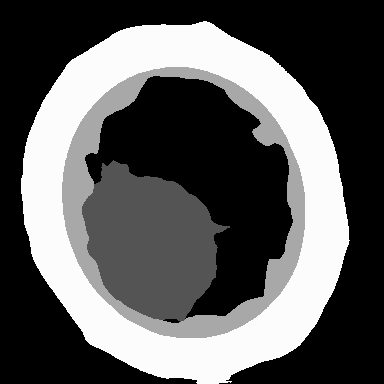

(384, 384)

In [ ]:
output_collapsed = torch.argmax(output, 1).squeeze().cpu().numpy()
cv2_imshow(output_collapsed * 84)
output_collapsed.shape

In [ ]:
def plot_predictions(image, prediction, gt):
    fig, axes = plt.subplots(4, 4, figsize = (18,12), sharey=True)
    image = image.permute((1,2,0))
    # plt.title('Результаты сегментации на примере одного изображения', y=1.08)
    fig.suptitle('Результаты сегментации на примере одного изображения', y=1.03)
    fig = fig.tight_layout()

    cols = ['Background', 'ICM', 'TE', 'ZP']
    rows = ['Изображение', 'GT\nмаска', 'Предсказанная\nмаска', 'Сравнение\nмасок']


    for ax, row in zip(axes[0], rows):
        ax.set_title(row)

    # for ax, row in zip(axes[:,0], rows):
    #     ax.set_ylabel(row, rotation=0, size='large', position=(-1.5,0.5))

    preds = []
    for i in range(4):
        axes[i][0].imshow(image) # image itself
        axes[i][0].set_ylabel(cols[i])

        pred_layer = np.ones_like(prediction)

        single_target_gt = torch.zeros_like(gt)
        single_target_gt = torch.where(gt == i, single_target_gt.long(), 1)
        single_target_gt = single_target_gt.cpu().numpy()
        single_target_gt = np.ma.masked_where(single_target_gt == 1, single_target_gt)

        axes[i][1].imshow(image)
        axes[i][1].imshow(single_target_gt, cmap='jet', alpha=0.7, interpolation='none') # gt mask

        pred_layer = np.ma.masked_where(prediction != i, pred_layer, copy=True)
        preds.append(pred_layer)
        axes[i][2].imshow(image)
        axes[i][2].imshow(pred_layer, cmap='jet', alpha=0.7, interpolation='none')

        axes[i][3].imshow(image)
        axes[i][3].imshow(pred_layer, cmap='gist_rainbow', alpha=0.7, interpolation='none')
        axes[i][3].imshow(single_target_gt, cmap='jet', alpha=0.7, interpolation='none')



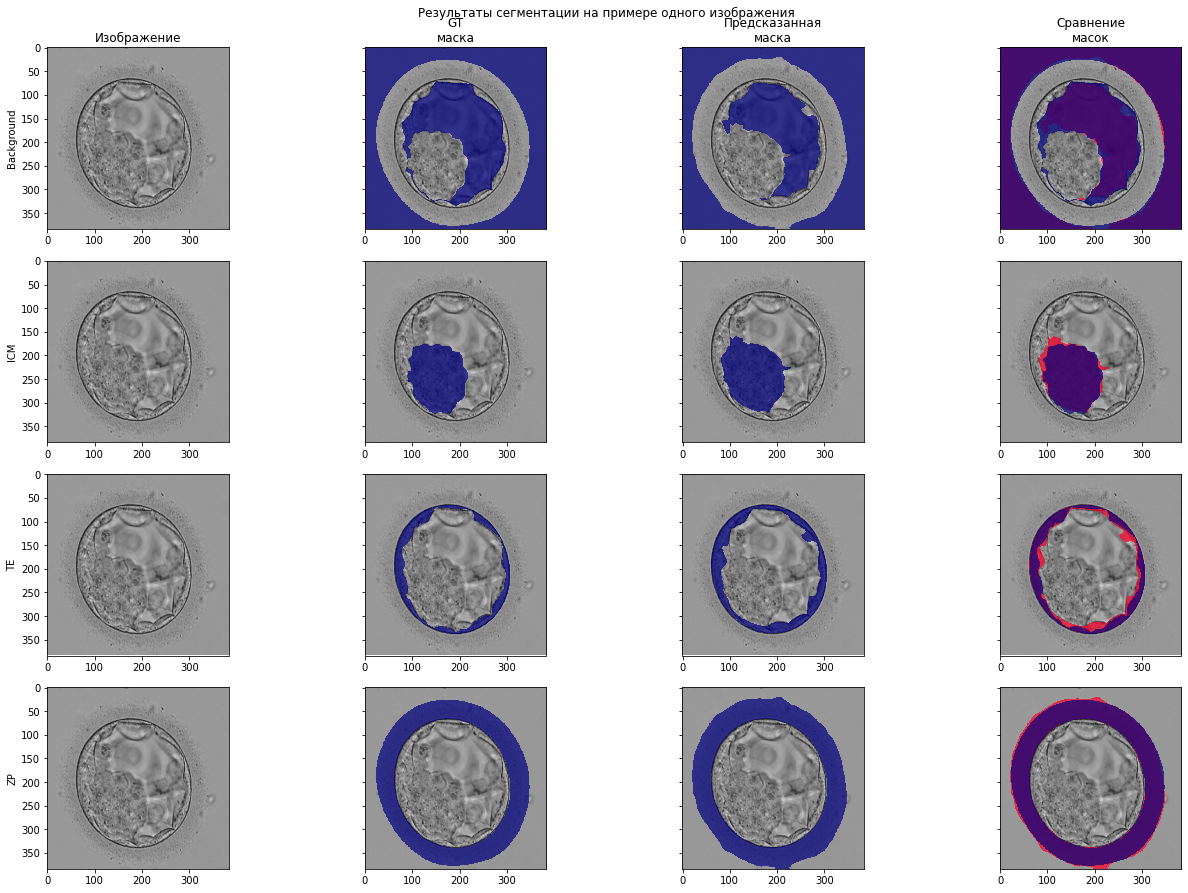

In [ ]:
image = cv.imread(img_path[0][0])
image = augmentation_transform(image=image)['image']
image = torch.Tensor(image).permute((2,0,1)).int()
prediction = output_collapsed
gt = stored_images[1][0]

plot_predictions(image, prediction, gt)